In [1]:
import logging
import time
from model import ProposalModel
from pathlib import Path
import astropy.table
from diskchef.lamda.line import Line
from diskchef.physics.yorke_bodenheimer import YorkeBodenheimer2008
from astropy import units as u
import numpy as np
import emcee
from multiprocessing import Pool
import tempfile

In [2]:
data_folder = Path("Default")

data = astropy.table.QTable.read(data_folder / "fluxes.ecsv")

lines = [
    Line(name='HCN J=3-2', transition=3, molecule='HCN'),
    Line(name='HCO+ J=3-2', transition=3, molecule='HCO+'),
    Line(name='N2H+ J=3-2', transition=3, molecule='N2H+'),
    Line(name='CO J=2-1', transition=2, molecule='CO'),
]

data["Error"] = 0.1 * data["Flux"]
data

Transition,Flux,Error
,km mJy / s,km mJy / s
str10,float64,float64
HCN J=3-2,1558.7993018633028,155.87993018633028
HCO+ J=3-2,687.4397015323481,68.74397015323481
N2H+ J=3-2,225.2547370384128,22.525473703841282
CO J=2-1,1967.1088553763839,196.7108855376384


In [8]:
yb = YorkeBodenheimer2008()


def lnprob(params):
    mass = params[0] * u.M_sun
    if params[0] <= 0: return -np.inf
    if params[3] <= 0: return -np.inf
    folder = Path(tempfile.mkdtemp(prefix="fit_", dir="fit2"))
    try:
        demo_model = ProposalModel(
            disk="Fit",
            line_list=lines,
            params=dict(r_min=1 * u.au, r_max=300 * u.au, radial_bins=40, vertical_bins=40),
            rstar=yb.radius(mass),
            tstar=yb.effective_temperature(mass),
            inc=params[1] * u.deg,
            PA=params[2] * u.deg,
            distance=params[3] * u.pc,
            nphot_therm=3e5,
            npix=51,
            channels=51,
            folder=folder,
            run_mctherm=False,
        )
        fluxes = astropy.table.QTable.read(folder / "fluxes.ecsv")
        if not np.all(fluxes["Transition"] == data["Transition"]):
            raise ValueError("Wrong order of transitions")

        chi_squared = np.sum(((data["Flux"] - fluxes["Flux"]) / data["Error"]) ** 2)
    except Exception as e:
        logging.error(e)
        return -np.inf
    return -0.5 * chi_squared

In [4]:
nwalkers = 8
ndims = 4
nsteps = 4
trues = np.array([1, 30, 25, 150])

initials = np.random.uniform(0.5, 2, [nwalkers, ndims]) * trues

In [9]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnprob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initials, nsteps, progress=True)
    end = time.time()

 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_xynzorxk/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_xynzorxk/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_xynzorxk/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_xynzorxk/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_y7aqzyb8/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_y7aqzyb8/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_y7aqzyb8/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_y7aqzyb8/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition ra

Reading fit2/fit_4jpoykk3/radmc_gas/CO J=2-1_image.out


Reading fit2/fit_5yhdu0ur/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_4jpoykk3/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_5yhdu0ur/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_4jpoykk3/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_5yhdu0ur/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_4jpoykk3/radmc_gas/N2H+ J=3-2_image.out
Reading fit2/fit_5yhdu0ur/radmc_gas/N2H+ J=3-2_image.out




 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_c2y5emo1/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_c2y5emo1/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_c2y5emo1/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_c2y5emo1/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_mmwh9e7o/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_mmwh9e7o/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_mmwh9e7o/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_mmwh9e7o/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_915hvr7g/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_915hvr7g/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_915hvr7g/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_915hvr7g/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_fj_ym7_f/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_fj_ym7_f/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_fj_ym7_f/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_fj_ym7_f/radmc_gas/N2H+ J=3-2_image.out


  0%|          | 0/4 [00:00<?, ?it/s] In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_yyixp944/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_yyixp944/radmc_gas/HCN J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition ra

Reading fit2/fit_yyixp944/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_yyixp944/radmc_gas/N2H+ J=3-2_image.out


Reading fit2/fit_6a4hoh3e/radmc_gas/CO J=2-1_image.out


Reading fit2/fit_cjj2jt9e/radmc_gas/CO J=2-1_image.out


Reading fit2/fit_6a4hoh3e/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_cjj2jt9e/radmc_gas/HCN J=3-2_image.out


Reading fit2/fit_6a4hoh3e/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_cjj2jt9e/radmc_gas/HCO+ J=3-2_image.out


Reading fit2/fit_6a4hoh3e/radmc_gas/N2H+ J=3-2_image.out
Reading fit2/fit_cjj2jt9e/radmc_gas/N2H+ J=3-2_image.out


: PossiblySlowWarning: This function (<function BaseSpectralCube.to at 0x7f8eb33619d0>) requires loading the entire cube into memory and may therefore be slow. [spectral_cube.utils]
 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_f27lj41j/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_f27lj41j/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_f27lj41j/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_f27lj41j/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition ra

Reading fit2/fit_rtkyp_p5/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_rtkyp_p5/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_qt__5jqm/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_rtkyp_p5/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_qt__5jqm/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_rtkyp_p5/radmc_gas/N2H+ J=3-2_image.out
Reading fit2/fit_qt__5jqm/radmc_gas/HCO+ J=3-2_image.out


Reading fit2/fit_qt__5jqm/radmc_gas/N2H+ J=3-2_image.out



: PossiblySlowWarning: This function (<function BaseSpectralCube.sum at 0x7f8eb335c670>) requires loading the entire cube into memory and may therefore be slow. [spectral_cube.utils]

 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_xg2pqesm/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_xg2pqesm/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_xg2pqesm/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_xg2pqesm/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_4ud0nmq3/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_4ud0nmq3/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_4ud0nmq3/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_4ud0nmq3/radmc_gas/N2H+ J=3-2_image.out


 25%|██▌       | 1/4 [08:54<26:42, 534.05s/it] In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_s9pwml0d/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_s9pwml0d/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_s9pwml0d/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_s9pwml0d/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition ra

Reading fit2/fit_hndq6ekd/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_hndq6ekd/radmc_gas/HCN J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_hndq6ekd/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_cy7qp6li/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_hndq6ekd/radmc_gas/N2H+ J=3-2_image.out
Reading fit2/fit_cy7qp6li/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_cy7qp6li/radmc_gas/HCO+ J=3-2_image.out


Reading fit2/fit_eet_lgsk/radmc_gas/CO J=2-1_image.out


Reading fit2/fit_cy7qp6li/radmc_gas/N2H+ J=3-2_image.out


Reading fit2/fit_eet_lgsk/radmc_gas/HCN J=3-2_image.out


Reading fit2/fit_eet_lgsk/radmc_gas/HCO+ J=3-2_image.out


: PossiblySlowWarning: This function (<function BaseSpectralCube.sum at 0x7f8eb335c670>) requires loading the entire cube into memory and may therefore be slow. [spectral_cube.utils]


Reading fit2/fit_eet_lgsk/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_q9bnmgss/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_q9bnmgss/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_q9bnmgss/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_q9bnmgss/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_g4zyvhot/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_g4zyvhot/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_g4zyvhot/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_g4zyvhot/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_mynq7i3x/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_mynq7i3x/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_mynq7i3x/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_mynq7i3x/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_n0tnvfk0/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_n0tnvfk0/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_n0tnvfk0/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_n0tnvfk0/radmc_gas/N2H+ J=3-2_image.out


 50%|█████     | 2/4 [18:09<18:13, 546.90s/it] In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_ggfadu2b/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_ggfadu2b/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_ggfadu2b/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_ggfadu2b/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition ra

Reading fit2/fit_wa1wpkz8/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_wa1wpkz8/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_wa1wpkz8/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_53tf8unb/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_wa1wpkz8/radmc_gas/N2H+ J=3-2_image.out
Reading fit2/fit_53tf8unb/radmc_gas/HCN J=3-2_image.out


Reading fit2/fit_53tf8unb/radmc_gas/HCO+ J=3-2_image.out


Reading fit2/fit_53tf8unb/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_rkzq0vyl/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_rkzq0vyl/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_rkzq0vyl/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_rkzq0vyl/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_tht1hkuc/radmc_gas/CO J=2-1_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_tht1hkuc/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_tht1hkuc/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_xdc00cb_/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_tht1hkuc/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_xdc00cb_/radmc_gas/HCN J=3-2_image.out


Reading fit2/fit_xdc00cb_/radmc_gas/HCO+ J=3-2_image.out


Reading fit2/fit_xdc00cb_/radmc_gas/N2H+ J=3-2_image.out


Reading fit2/fit_6gc6vffy/radmc_gas/CO J=2-1_image.out


Reading fit2/fit_6gc6vffy/radmc_gas/HCN J=3-2_image.out


Reading fit2/fit_6gc6vffy/radmc_gas/HCO+ J=3-2_image.out


Reading fit2/fit_6gc6vffy/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit__5u9j2dk/radmc_gas/CO J=2-1_image.out
Reading fit2/fit__5u9j2dk/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit__5u9j2dk/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit__5u9j2dk/radmc_gas/N2H+ J=3-2_image.out


 75%|███████▌  | 3/4 [26:40<08:50, 530.13s/it] In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_6mmt48ow/radmc_gas/CO J=2-1_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_6mmt48ow/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_6mmt48ow/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_6mmt48ow/radmc_gas/N2H+ J=3-2_image.out
Reading fit2/fit_037sr90z/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_037sr90z/radmc_gas/HCN J=3-2_image.out


Reading fit2/fit_037sr90z/radmc_gas/HCO+ J=3-2_image.out


Reading fit2/fit_037sr90z/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_z_1kh8mt/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_z_1kh8mt/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_z_1kh8mt/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_z_1kh8mt/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_z3cory4n/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_z3cory4n/radmc_gas/HCN J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_z3cory4n/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_z3cory4n/radmc_gas/N2H+ J=3-2_image.out


Reading fit2/fit__6mz107p/radmc_gas/CO J=2-1_image.out


Reading fit2/fit__6mz107p/radmc_gas/HCN J=3-2_image.out


Reading fit2/fit__6mz107p/radmc_gas/HCO+ J=3-2_image.out


Reading fit2/fit__6mz107p/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_syl6a9o0/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_syl6a9o0/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_syl6a9o0/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_syl6a9o0/radmc_gas/N2H+ J=3-2_image.out


 In the molecular data file for molecule 1
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.

 In the molecular data file for molecule 2
          there are collisional transition rates specified
          for 2 collision partners.
          However, in lines.inp for this line only 1
          names of the collision partners are given.
          We will therefore use not all possible partners.



Reading fit2/fit_l75m9a86/radmc_gas/CO J=2-1_image.out
Reading fit2/fit_l75m9a86/radmc_gas/HCN J=3-2_image.out
Reading fit2/fit_l75m9a86/radmc_gas/HCO+ J=3-2_image.out
Reading fit2/fit_l75m9a86/radmc_gas/N2H+ J=3-2_image.out


100%|██████████| 4/4 [35:53<00:00, 538.30s/it]


In [11]:
sampler.flatchain

array([[  0.96173534,  78.70009593,  47.92776511, 142.60588138],
       [  0.52528881,  20.15078227,  14.82040559, 207.89336829],
       [  0.6361321 ,  34.3267742 ,  21.58227746, 136.61669071],
       [  1.61981197,  27.5494455 ,  29.36589308,  75.43650495],
       [  0.74224058,  35.4095918 ,  34.0134012 , 250.36009161],
       [  1.36189501,  18.40709814,  12.67457327, 245.38689523],
       [  0.94466917,  25.84039962,  37.29857532, 275.60843021],
       [  1.32075203,  16.60623677,  15.69059741, 289.52673691],
       [  0.91998605,  73.52291374,  44.67712607, 146.55951582],
       [  0.44280682,  14.34959955,   7.52350118, 191.74812308],
       [  0.6361321 ,  34.3267742 ,  21.58227746, 136.61669071],
       [  1.61981197,  27.5494455 ,  29.36589308,  75.43650495],
       [  0.74224058,  35.4095918 ,  34.0134012 , 250.36009161],
       [  1.35849635,  18.91918184,  12.97398756, 244.51395003],
       [  0.88939554,  27.19756253,  40.47434196, 273.56282953],
       [  1.32075203,  16

In [12]:
from matplotlib import pyplot as plt
import pickle

In [13]:
with open("fit2/sampler.pkl", "wb") as pkl:
    pickle.dump(sampler, pkl)

In [35]:
import corner
import matplotlib.colors, matplotlib.cm

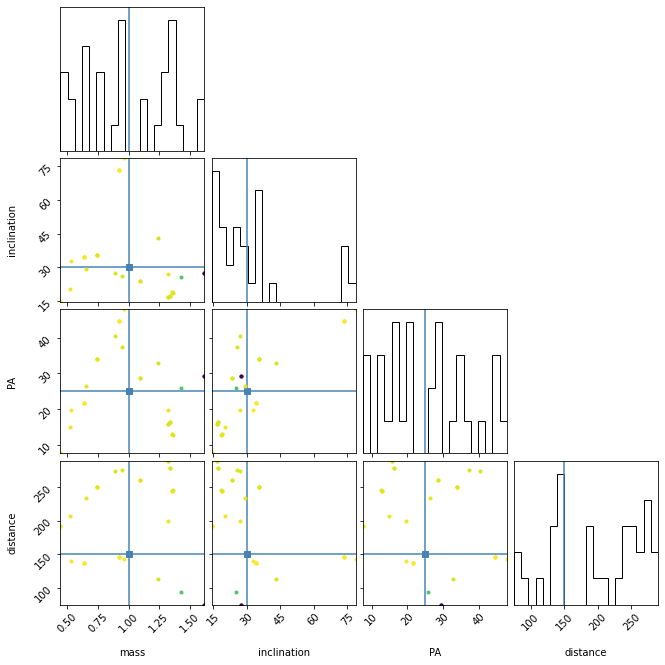

In [38]:
fig = corner.corner(sampler.flatchain, labels=["mass", "inclination", "PA", "distance"], truths=trues,
                    plot_contours=False, plot_density=False)
for point, color in zip(
        sampler.flatchain,
        matplotlib.cm.get_cmap("viridis")(
            matplotlib.colors.Normalize()(sampler.flatlnprobability)
        )
):
    corner.overplot_points(
        fig, [point], color=color
    )

In [33]:
matplotlib.colors.Normalize()(sampler.flatlnprobability)

masked_array(data=[0.99973794, 0.97724924, 0.99571857, 0.        ,
                   0.95568334, 0.95956426, 0.94679346, 0.94324862,
                   1.        , 0.9851177 , 0.99571857, 0.        ,
                   0.95568334, 0.95990774, 0.94756137, 0.94324862,
                   1.        , 0.9851177 , 0.99571857, 0.72594774,
                   0.95568334, 0.95990774, 0.95209115, 0.94684331,
                   1.        , 0.9851177 , 0.99829558, 0.93449796,
                   0.96364335, 0.98042699, 0.95209115, 0.94684331],
             mask=False,
       fill_value=1e+20)